# Hierachical fit given previous sampling

## Loading samples

In [88]:
from random import randint
from scipy.special import logsumexp
from __future__ import print_function
import matplotlib
import matplotlib.pyplot as plt
from pylab import subplots_adjust
from matplotlib.ticker import MaxNLocator
import corner
%matplotlib inline
import os.path
import os
import sys
import pandas as pd
import numpy as np
#from matplotlib import gridspec

In [89]:
def random_sample(trace):
    ''' '''
    size = np.shape(trace)
    no_of_samples = size[1]
    N = randint(number_of_samples)
    sample_draw = trace[N,:]
    
    return sample_draw

In [156]:
def load_data(data_file):
    ''' '''
    if os.path.exists(data_file):
        samples = pd.read_csv(data_file) #loads trace file as numpy array
        header = list(samples.columns.values)
        keep = header[1:]       # getting rid of the excess indexing column from save and load processes used
        samples = samples[keep] #
        ## converting to a numpy array
        samples = np.array(samples)
        size = np.shape(samples)
        return samples, keep
    else:
        return None, None

In [158]:
def collect_trace_files(model='PointSourcePointLens'):
    ''' '''
    base_directory = 'output'
    #base_directory = 'fit_data'
    event_names = get_event_names(base_directory) #list of events names in a data directory
    #event_names = get_event_names('fit_data')
    i=0
    for event in event_names: #for each of the events
        data_file = base_directory+'/'+event+'/'+model+'/data.csv' #location of the data frame files
        #trace_file = base_directory+'/'+event+'/'+model+'/model.pkl'
        samples, header = load_data(data_file) #loads loads dataframe and converts to a numpy array
        if i==0:
            if samples is not None:
                master_samples = np.array([samples])
        else:
            if samples is not None:
                master_samples = np.vstack((master_samples,np.array([samples])))
        i+=1
        
    return master_samples, header

In [151]:
def get_event_names(data_dir):
    output_folder = [f for f in os.listdir(data_dir) if os.path.exists(os.path.join(data_dir, f))]
    event_nameS = []
    for event_name in output_folder:
        #event_name = dataset.replace('.csv','')
        event_nameS.append(event_name)
    #event_nameS = ['OGLE-2017-BLG-0240','OGLE-2017-BLG-0315','OGLE-2017-BLG-0375']
    print(event_nameS)
    #sys.exit()
    return event_nameS

## emcee

In [138]:
def lndiff(theta,lnp0_x,x):
    mu, sig = theta
    top = -1.0*((x-mu)**2.0/sig**2.0)
    return top-lnp0_x

In [142]:
def lnlike(theta,lnp0_x,x):
    ''' '''
    #The very complicated calculation
    #prob in likelihood becomes a sum in ln
    #sum log diff in K direction then N direction
    # K is the chain length
    # N is the number of lightcurves
    
    diff = lndiff(theta,lnp0_x,x) 
    chain_sum = logsumexp(diff,axis=1) # *1/K
    data_sets_sum = np.sum(chain_sum,axis=0)
    p = 0.0 #probability of the data given nuisance parameters
    return p + data_sets_sum
    

In [133]:
def lnprob(theta, lnp0_x,x):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta,lnp0_x,x)

In [134]:
def lnprior(theta):
    ''' '''
    return 0.0

In [160]:
def run_emcee(p0,data,x_index):
    ''' '''
    ndim, nwalkers = 2, 100
    burnin = 50
    #pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    lnp0_x = data[:,:,x_index+8] #3D array collapsed to a 2D array for one parameter
    x = data[:,:,x_index] #x represents the lightcurve parameter
    pos = [p0+1e-7*np.random.randn(ndim) for i in range(nwalkers)]
    import emcee
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(lnp0_x, x))
    sampler.run_mcmc(pos, 500)
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    np.save('samples.npy',samples)
    parameter_labels = ['ln(mu)','ln(sig)']
    plot_chain(sampler,parameter_labels)
    plot_chain_corner(parameter_labels, samples)
    

In [132]:
def plot_chain(s,parameter_labels,index=None,plot_lnprob=True,suffix=''):
    if index is None:
        index = range(s.chain.shape[2])
    n_plots = len(index)
    plt.figure(figsize=(8,11))
    subplots_adjust(hspace=0.0001)
    for i in range(n_plots):
        if i == 0:
            plt.subplot(n_plots+plot_lnprob,1,i+1)
            ax1 = plt.gca()
        else:
            plt.subplot(n_plots+plot_lnprob,1,i+1,sharex=ax1)
        
        plt.plot(s.chain[:,:,index[i]].T, '-', color='k', alpha=0.3)
        plt.ylabel(parameter_labels[i])
        ax = plt.gca()

        if i < n_plots-1 + plot_lnprob:
            plt.setp(ax.get_xticklabels(), visible=False)
            ax.yaxis.set_major_locator(MaxNLocator(prune='lower'))
            ax.locator_params(axis='y',nbins=4)

    if plot_lnprob:
        plt.subplot(n_plots+plot_lnprob,1,n_plots+plot_lnprob,sharex=ax1)
        plt.plot(s.lnprobability.T, '-', color='r', alpha=0.3)
        plt.ylabel(r"$ln P$")
        ax = plt.gca()
        ax.yaxis.set_major_locator(MaxNLocator(prune='lower'))
        ax.locator_params(axis='y',nbins=4)

    plt.savefig('chain'+suffix)
    plt.close()

In [119]:
def plot_chain_corner(parameter_labels,samples):
    figure = corner.corner(samples,labels=parameter_labels,quantiles=[0.16, 0.5, 0.84], show_titles=True, title_args={"fontsize": 12})
    figure.savefig('pdist.png')

In [136]:
def main():
    ''' '''
    data, header = collect_trace_files() #posterior samples for many light curves as 3D array
    print(header)
    p0 = (1.0,1.5) #mu and sigma guesses for tE
    parameter_index = 4 #for tE
    run_emcee(p0,data,parameter_index)
    

['OGLE-2017-BLG-0375', 'OGLE-2017-BLG-1433', 'OGLE-2017-BLG-1611', 'OGLE-2017-BLG-0804', 'OGLE-2017-BLG-1057', 'OGLE-2017-BLG-0240', 'OGLE-2017-BLG-0938', 'OGLE-2017-BLG-1735', 'OGLE-2017-BLG-1087', '.DS_Store', 'OGLE-2017-BLG-0315']
['Fb', 'DeltaF', 't0', 'u0', 'tE', 'm_source', 'm_blend', 'K', 'logp_DeltaF', 'logp_Fb', 'logp_t0', 'logp_u0', 'logp_tE', 'logp_K', 'log_posterior']


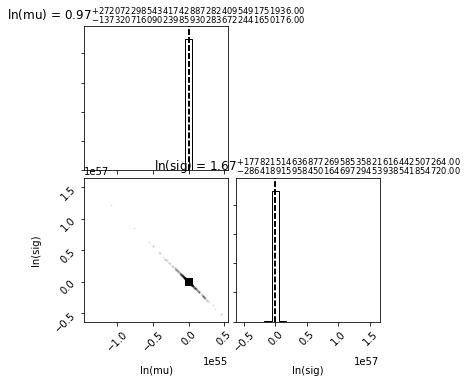

In [161]:
if __name__ == '__main__':
    main()

## Testing

In [53]:
def pretend_arrays():
    ''' '''
    A = np.ones([2,5])
    A[:,3] = 10.0
    B = np.ones([2,5])*2.0
    B[:,3] = 20.0
    C = np.ones([2,5])*3.0
    C[:,3] = 30.0

    stack = [A,B,C]

    i=0
    for mat in stack: #find a faster way to do this
        if i==0:
            array3D = np.array([mat])
        else:
            array3D = np.vstack((array3D,np.array([mat])))
        i+=1
    
    print(array3D)
    return array3D

array = pretend_arrays()

col = array[:,:,3]
print(col)
col_sum = logsumexp(col,axis=1)
print(col_sum)

[[[ 1.  1.  1. 10.  1.]
  [ 1.  1.  1. 10.  1.]]

 [[ 2.  2.  2. 20.  2.]
  [ 2.  2.  2. 20.  2.]]

 [[ 3.  3.  3. 30.  3.]
  [ 3.  3.  3. 30.  3.]]]
[[10. 10.]
 [20. 20.]
 [30. 30.]]
[10.69314718 20.69314718 30.69314718]


In [54]:
print(np.log(np.exp(10)+np.exp(10)))


10.693147180559945
